In [1]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from dl4cv.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027207103e-08


In [3]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.79412040779e-13


In [5]:
from dl4cv.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
  print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))
  #print(param_grad_num, grads[param_name])

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447677e-11
W1 max relative error: 3.669857e-09
b1 max relative error: 2.738421e-09


Final training loss:  0.015166823639


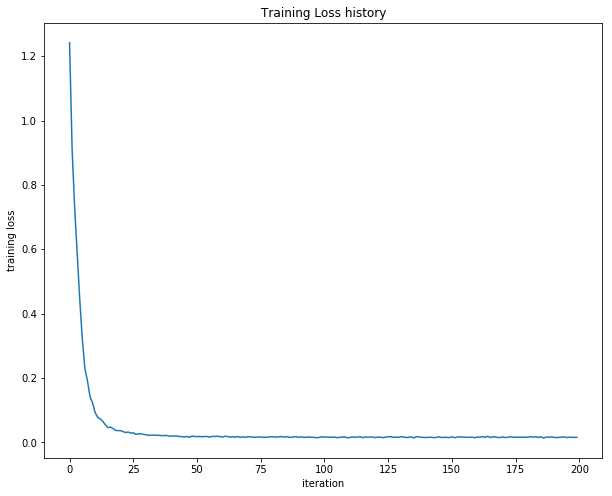

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=200, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

Train data shape:  (48000, 3072)
Train labels shape:  (48000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


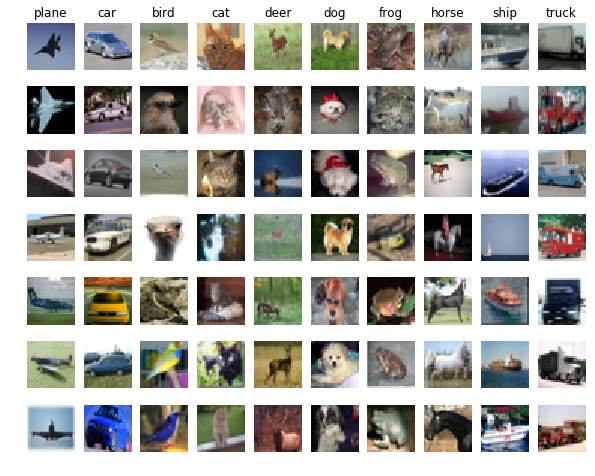

In [8]:
from dl4cv.data_utils import load_CIFAR10
from dl4cv.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. 
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]
    
    # We will also make a development set, which is a small subset of
    # the training set. This way the development cycle is faster.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev= get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

In [10]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1500: loss 2.302997
iteration 100 / 1500: loss 2.302601
iteration 200 / 1500: loss 2.298924
iteration 300 / 1500: loss 2.273897
iteration 400 / 1500: loss 2.194577
iteration 500 / 1500: loss 2.120545
iteration 600 / 1500: loss 2.058732
iteration 700 / 1500: loss 1.999296
iteration 800 / 1500: loss 2.025202
iteration 900 / 1500: loss 1.998723
iteration 1000 / 1500: loss 1.920770
iteration 1100 / 1500: loss 1.914354
iteration 1200 / 1500: loss 1.993594
iteration 1300 / 1500: loss 1.956476
iteration 1400 / 1500: loss 1.868577
Validation accuracy:  0.317


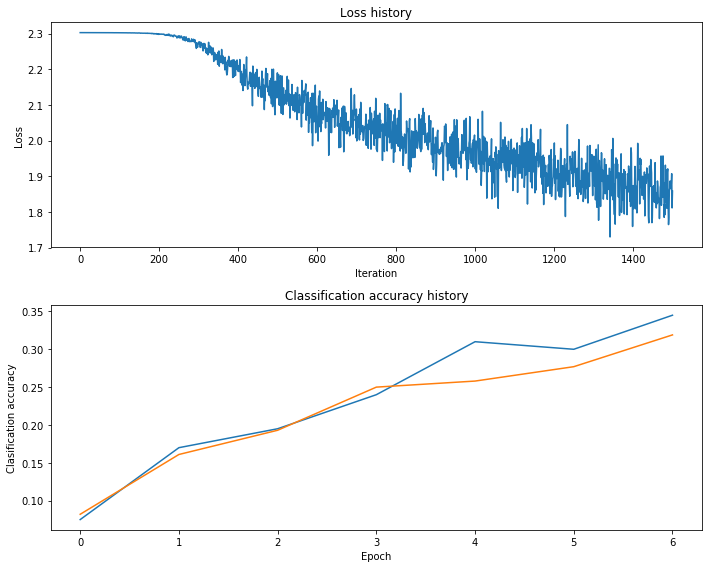

In [11]:
# Plot the loss function and train / validation accuracies
plt.subplots(nrows=2, ncols=1)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')

plt.tight_layout()
plt.show()

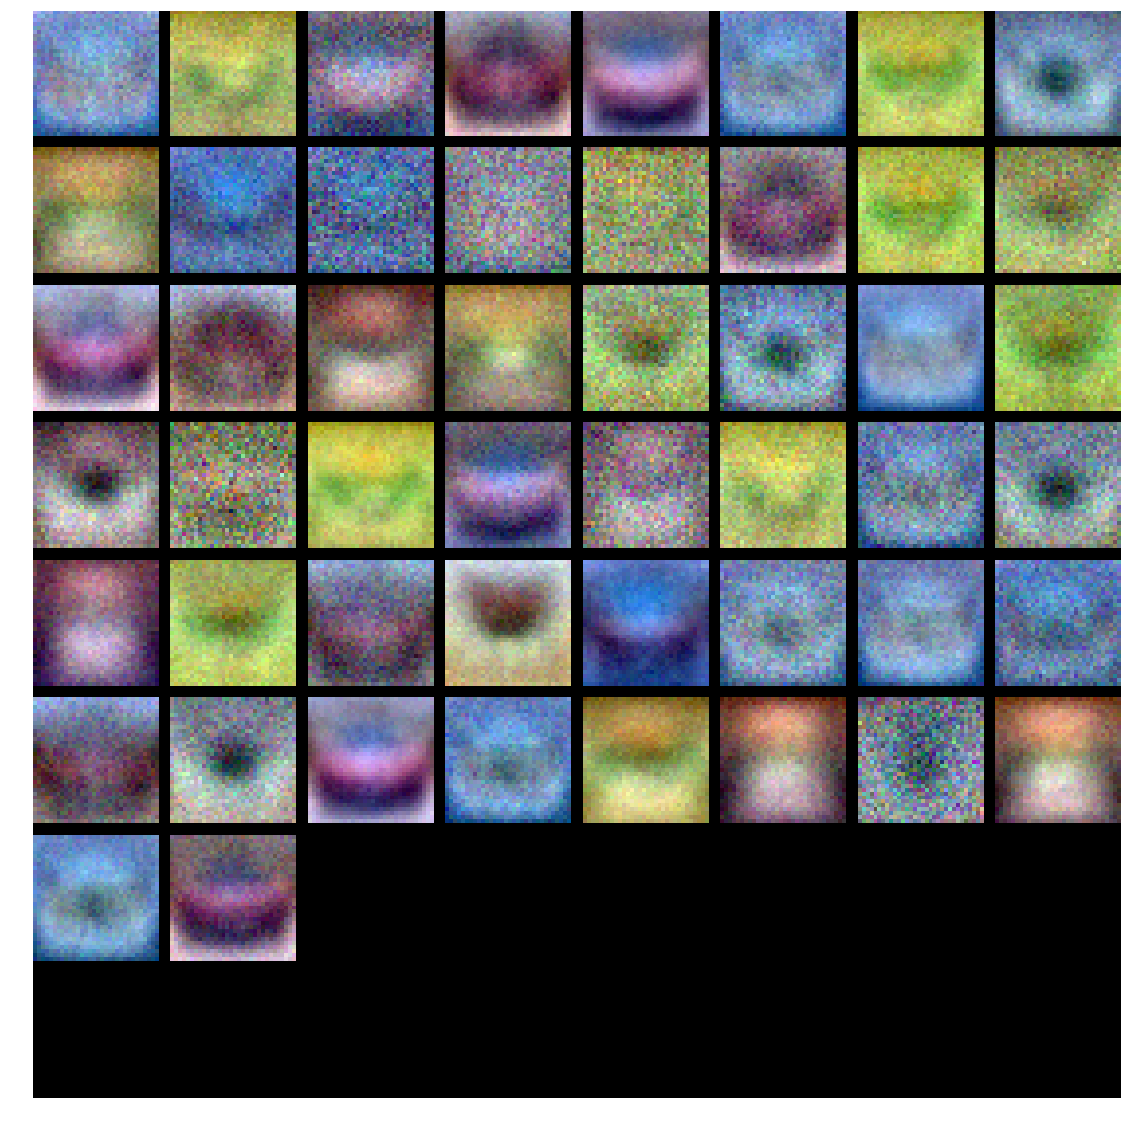

In [12]:
from dl4cv.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    fig = plt.figure(figsize=(20,20))
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

In [13]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.33
